# **Setup & Imports**

In [21]:
from google.colab import drive

import sys, os


In [2]:
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
PROJECT = "path/to/your/project"

sys.path.append(f"{PROJECT}/src")


In [17]:
# Install all deps listed in your project's requirements.txt

!pip -q install -r {PROJECT}/requirements.txt

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import json
import torch
import os

from pprint import pprint
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments
from datasets import DatasetDict

from language_id.data import load_wili
from language_id.preprocess import apply_cleaning_ds
from language_id.data import stratified_subset
from language_id.data import make_train_val
from language_id.preprocess import tokenize_ds
from language_id.utils import set_seed, save_json, load_json
from language_id.tune import run_study
from language_id.train import run_final_training
from language_id.utils import load_json


import joblib
import optuna
import sys, math, time
import numpy as np

from pathlib import Path
from datasets import load_from_disk, Dataset
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split






In [ ]:
set_seed(42) # default; replace with custom seed for reproducibility

# **Data Understanding**

## **Data Inspection**

In [7]:
ds, text_col, label_col = load_wili()

# Basic sizes
print("Train:", ds["train"].num_rows)
print("Test :", ds["test"].num_rows)



Train: 117500
Test : 117500


In [ ]:
# Column names
print("Columns:", ds["train"].column_names)

Columns: ['sentence', 'label']


In [8]:
# Label names (codes)
label_names_train = ds["train"].features[label_col].names  # e.g., 'ar', 'en', ...
print("Number of languages in Train:", len(label_names_train))
print("First 10 codes in Train:", label_names_train[:10])

label_names_test = ds["test"].features[label_col].names  # e.g., 'ar', 'en', ...
print("Number of languages in Test:", len(label_names_test))
print("First 10 codes in Test:", label_names_test[:10])


Number of languages in Train: 235
First 10 codes in Train: ['cdo', 'glk', 'jam', 'lug', 'san', 'rue', 'wol', 'new', 'mwl', 'bre']
Number of languages in Test: 235
First 10 codes in Test: ['cdo', 'glk', 'jam', 'lug', 'san', 'rue', 'wol', 'new', 'mwl', 'bre']


#### **Convert to Pandas (for EDA convenience)**

In [9]:
df_train = ds["train"].to_pandas()
df_test  = ds["test"].to_pandas()

In [17]:
# Displaying the first few rows of the Datasplits

print(f"Train Datasplit: {df_train.head()}")
print(f"Test Datasplit: {df_test.head()}")


Train Datasplit:                                             sentence  label
0  Klement Gottwaldi surnukeha palsameeriti ning ...    112
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....     93
2  भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...     83
3  Après lo cort periòde d'establiment a Basilèa,...    176
4  ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...     42
Test Datasplit:                                             sentence  label
0  Ne l fin de l seclo XIX l Japon era inda çconh...      8
1  Schiedam is gelegen tussen Rotterdam en Vlaard...    185
2  ГIурусаз батальонал, гьоркьор гIарадабиги лъун...     28
3  ರಾಜ್ಯಶಾಸ್ತ್ರದ ಪಿತಾಮಹೆ ಅರಿಸ್ಟಾಟಲ್. ರಾಜ್ಯಶಾಸ್ತ್ರ...    231
4  Halukum adalah kelenjar tiroid nang menonjol d...    121


In [ ]:
# getting number of rows and columns for the dataset

print(f"Number of Rows and Columns in the Train Datasplit: {df_train.shape}")
print(f"Number of Rows and Columns in the Test Datasplit: {df_test.shape}")




Number of Rows and Columns in the Train Datasplit: (117500, 2)
Number of Rows and Columns in the Test Datasplit: (117500, 2)


In [ ]:
# getting the info of dataframes

print(f"Train Datasplit Info: {df_train.info()}")
print(f"Test Datasplit Info: {df_test.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117500 entries, 0 to 117499
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  117500 non-null  object
 1   label     117500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB
Train Datasplit Info: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117500 entries, 0 to 117499
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  117500 non-null  object
 1   label     117500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB
Test Datasplit Info: None


It is obvious that there are no Null values or duplicates in any of them as highlighted by the authors

In [11]:
# Map integer labels (0,1,2,...) → string codes ("ar","en",...)
df_train["Language"] = df_train[label_col].map(dict(enumerate(label_names_train)))
df_test["Language"] = df_test[label_col].map(dict(enumerate(label_names_test)))



**Distribution summary**

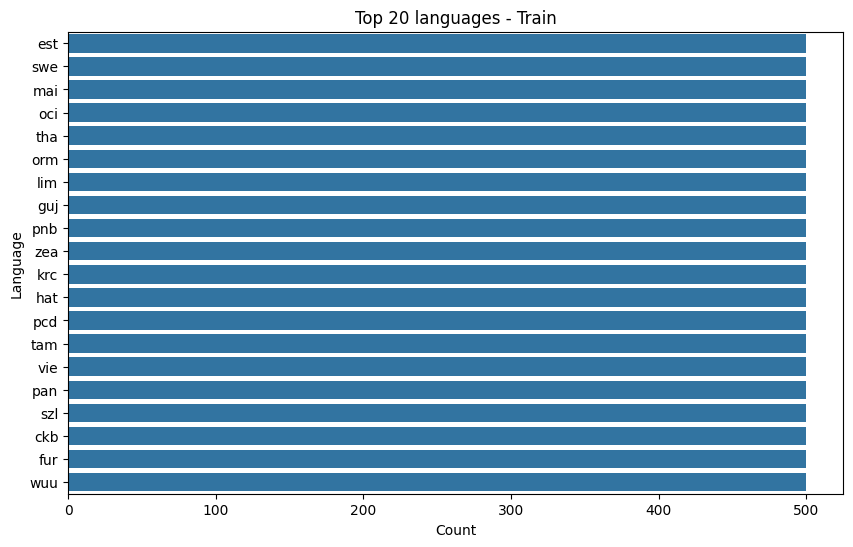

In [13]:

top_k = 20
lang_counts_train = df_train["Language"].value_counts().head(top_k)

plt.figure(figsize=(10, 6))
sns.barplot(y=lang_counts_train.index, x=lang_counts_train.values)
plt.title(f"Top {top_k} languages - Train")
plt.xlabel("Count")
plt.ylabel("Language")
plt.show()

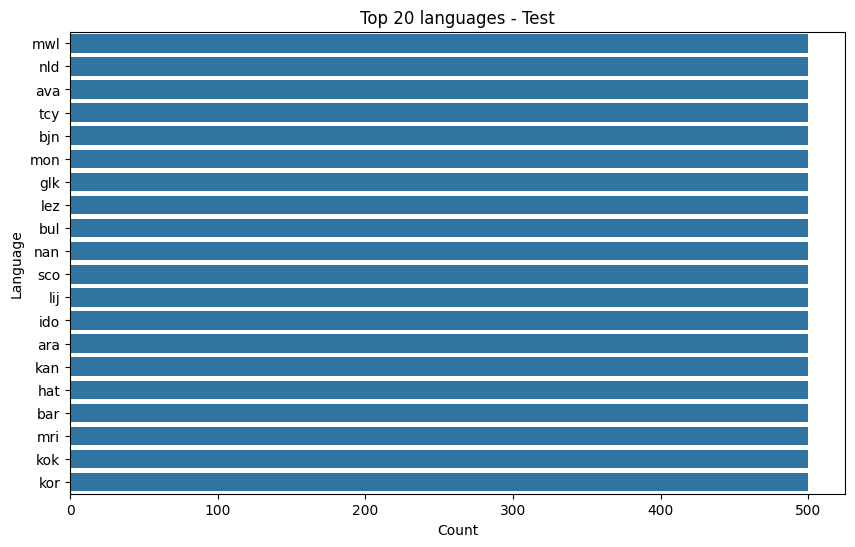

In [14]:
lang_counts_test = df_test["Language"].value_counts().head(top_k)

plt.figure(figsize=(10, 6))
sns.barplot(y=lang_counts_test.index, x=lang_counts_test.values)
plt.title(f"Top {top_k} languages - Test")
plt.xlabel("Count")
plt.ylabel("Language")
plt.show()

The distrubtion is even as mentioned by the authors

**Checking the Distribution of words for deciding on the LLM model (XLM-RoBERTa) max_length (padding/truncation)**

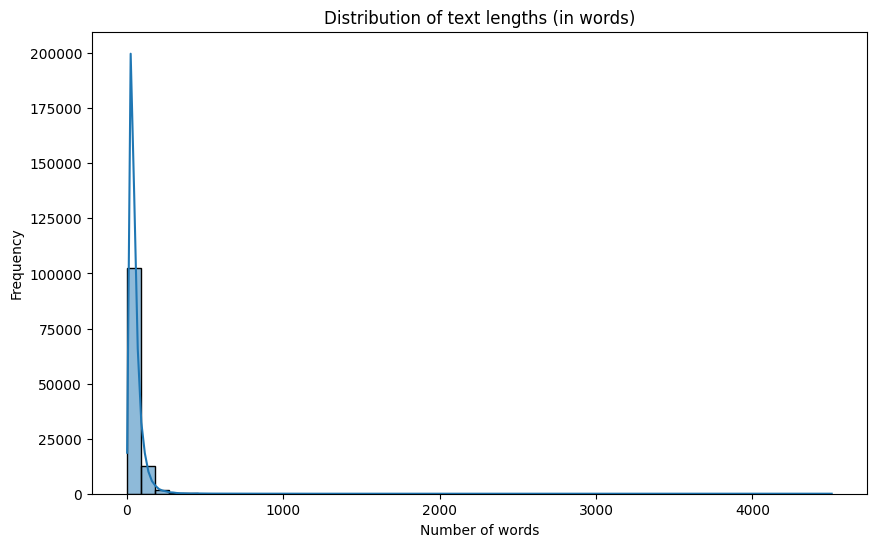

In [ ]:
# Count words
df_train["num_words"] = df_train["sentence"].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train["num_words"], bins=50, kde=True)
plt.title("Distribution of text lengths (in words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


In [ ]:

print(df_train.num_words.describe())

count    117500.000000
mean         54.550809
std          52.982298
min           1.000000
25%          28.000000
50%          41.000000
75%          65.000000
max        4507.000000
Name: num_words, dtype: float64


In [ ]:
print(df_train["num_words"].quantile(0.95))
print(df_train["num_words"].quantile(0.99))

132.0
231.0


The average text length in the training set was 54 words, with a median of 41 words. 95% of the texts contained ≤132 words, while 99% contained ≤231 words. The longest text contained 4,507 words, indicating the presence of extreme outliers.

To balance efficiency with coverage, the maximum sequence length will be set to **256** tokens. This threshold accommodates more than 99% of the training texts (≤231 words), while excluding rare outliers with excessive length (up to 4,507 words). In this way, unnecessary padding is avoided and truncation is minimized, ensuring that sufficient context is retained for longer texts.

# **Data Preparation**

Since the WiLI dataset is already cleaned by its authors, no major preprocessing was required. Only trivial cleaning was applied by removing leading/trailing whitespace

In [10]:
# Apply minimal cleaning

ds["train"] = apply_cleaning_ds(ds["train"], text_col=text_col)
ds["test"]  = apply_cleaning_ds(ds["test"], text_col=text_col)

**Splitting Train Datasplit into Train and Validation sets with 90% for training and 10% for Validation**

In [ ]:
# Make a train/val split from train (stratified, 90% train 10% val)
ds_train_val_test = make_train_val(ds, label_col=label_col, val_size=0.1, seed=42)

# Take each split alone
train_ds = ds_train_val_test["train"]
val_ds   = ds_train_val_test["validation"]
test_ds  = ds_train_val_test["test"]

In [ ]:
print(train_ds.shape)
print(val_ds.shape)
print(test_ds.shape)


(105750, 2)
(11750, 2)
(117500, 2)


**Saving the final train/ validate/ test splits to Google Drive for easier retrieval later and use by any model (ensuring the splits are consistent and not altered elsewhere)**

In [ ]:
data_out_dir = "path/to/your/data_output_directory"
os.makedirs(data_out_dir, exist_ok=True)

train_ds.save_to_disk(f"{data_out_dir}/train")
val_ds.save_to_disk(f"{data_out_dir}/validation")
test_ds.save_to_disk(f"{data_out_dir}/test")

Saving the dataset (0/1 shards):   0%|          | 0/105750 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11750 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/117500 [00:00<?, ? examples/s]

**Taking subsets of the training and validation sets for hyperparameter tuning with Optuna (subsets are used to reduce computational cost while preserving label balance)**


In [ ]:
# Make a train-subset/val-subset from train/val (stratified, 20% of the original splits was selected)
train_ds_subset = stratified_subset(train_ds, label_col=label_col, size=0.2, seed=42)
val_ds_subset = stratified_subset(val_ds, label_col=label_col, size=0.2, seed=42)



In [ ]:
print(train_ds_subset.shape)
print(val_ds_subset.shape)


(21150, 2)
(2350, 2)


In [ ]:
# save the subsets to Drive
data_subsets_out_dir = "path/to/your/data_subsets_output_directory"
os.makedirs(data_subsets_out_dir, exist_ok=True)

train_ds_subset.save_to_disk(f"{data_subsets_out_dir}/train_subset")
val_ds_subset.save_to_disk(f"{data_subsets_out_dir}/validation_subset")

Saving the dataset (0/1 shards):   0%|          | 0/21150 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2350 [00:00<?, ? examples/s]

**Loadind data splits and subsets from Google Drive**

In [ ]:
#Loading the full train\ validate\ test splits
from datasets import load_from_disk

train_ds = load_from_disk("path/to/your/train_split")
val_ds   = load_from_disk("path/to/your/data/validation_split")
test_ds  = load_from_disk("path/to/your/data/test_split")


In [ ]:
#Loading the train\ validate subsets for Optuna Tuning

train_ds_subset = load_from_disk("path/to/your/train_subset")
val_ds_subset   = load_from_disk("path/to/your/validation_subset")

In [13]:
print(f'Full Train Split Shape: {train_ds.shape}')
print(f'Full Validation Split Shape: {val_ds.shape}')
print(f'Full Test Split Shape: {test_ds.shape}')

print(f'Train Subset Shape: {train_ds_subset.shape}')
print(f'Validation Subset Shape: {val_ds_subset.shape}')


Full Train Split Shape: (105750, 2)
Full Validation Split Shape: (11750, 2)
Full Test Split Shape: (117500, 2)
Train Subset Shape: (21150, 2)
Validation Subset Shape: (2350, 2)


**Tokenizing using XLM-RoBERTa tokenizer**

In [14]:
# Load tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)



In [15]:
MAX_LEN = 256  # chosen from train distribution

# Tokenize subsets for Optuna
tok_train_ds_subset = tokenize_ds(train_ds_subset, tokenizer, text_col=text_col, max_length=MAX_LEN)
tok_val_ds_subset = tokenize_ds(val_ds_subset, tokenizer, text_col=text_col, max_length=MAX_LEN)

# Tokenize full for final training/val/test
tok_train_ds = tokenize_ds(train_ds, tokenizer, text_col=text_col, max_length=MAX_LEN)
tok_val_ds = tokenize_ds(val_ds, tokenizer, text_col=text_col, max_length=MAX_LEN)
tok_test_ds = tokenize_ds(test_ds, tokenizer, text_col=text_col, max_length=MAX_LEN)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")


# **Hyperparameter Tuning through Optuna**

We used Optuna with **20** **trials** to search over a medium-size hyperparameter space. This provided a balance between search coverage and computational cost.

**Hyperparameter Search Space (Optuna for XLM-R**)

The following hyperparameters were tuned with Optuna, using validation macro-F1 as the optimization objective:

- **Learning rate**: [1e-5, 5e-5]  
- **Batch size**: {16, 32}  
- **Number of epochs**: [2, 5]  
- **Weight decay**: [0.0, 0.1]  
- **Warmup ratio**: [0.0, 0.1]  

These ranges follow common practice in Transformer finetuning and were chosen to balance performance with available compute

In [16]:
# 3. CUDA / precision check
has_cuda = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name(0) if has_cuda else "CPU"
use_bf16 = has_cuda and any(k in gpu_name for k in ["A100", "L4"])

print("GPU:", gpu_name, "| bf16:", use_bf16, "| fp16:", has_cuda and not use_bf16)


GPU: NVIDIA A100-SXM4-40GB | bf16: True | fp16: False


In [17]:
# Build once (from train metadata)
label_names = ds["train"].features[label_col].names
id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in enumerate(label_names)}

In [ ]:
# creating a DatasetDict from the tokenized train\ val subsets
tok_sub = DatasetDict({
    "train": tok_train_ds_subset,
    "validation": tok_val_ds_subset
})


**Note**: For transparency and research integrity, the Optuna tuning script and search ranges are provided in this repository.

However, the exact best hyperparameters and full tuning logs are intentionally withheld to preserve the originality of ongoing and future research work.

You can reproduce comparable baseline-level results by re-running the Optuna search using the provided configuration and search space

In [ ]:
# Running Optuna Study

drive.mount('path/to/your/drive')

# then create your folder safely
trials_root_dir = "/path/to/your/xlm-r-optuna-trials"

os.makedirs(trials_root_dir, exist_ok=True)

best, best_path = run_study(
    tok_ds=tok_sub,
    model_name=model_name,
    id2label=id2label,
    label2id=label2id,
    n_trials=20, # 20 Trials
    study_name="xlmr_opt_subset",
    metrics_out_dir=f"{PROJECT}/outputs/metrics",
    trials_root_dir= trials_root_dir
)
print(best)
print("Saved:", best_path)





# **Finetuning xlm-RoBERTa on the full train\ val\ test Splits**

In [19]:
# creating a DatasetDict from the tokenized full train\ val \ test splits

tok_full = DatasetDict({
    "train": tok_train_ds,
    "validation": tok_val_ds,
    "test": tok_test_ds,
})

In [ ]:
best = load_json(f"{PROJECT}/outputs/metrics/xlmr_opt_subset_best_params.json")["best_params"]

output_dir_final = "path/to/your/xlm-runs/final_xlmr"
os.makedirs(output_dir_final, exist_ok=True)

trainer, val_metrics, test_metrics = run_final_training(
    tok_ds=tok_full,   # DatasetDict(train, validation, test)
    model_name="xlm-roberta-base",
    id2label=id2label,
    label2id=label2id,
    best_params=best,
    output_dir=output_dir_final,
    metrics_out=f"{PROJECT}/outputs/metrics",
    seed=42,
    early_patience=2,
)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/drive/MyDrive/language-id/src/language_id/train.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall
1,1.651400,0.242810,0.939404,0.938422,0.938422,0.948256,0.939404
2,0.201500,0.176663,0.956340,0.956082,0.956082,0.959000,0.956340
3,0.124800,0.158273,0.962979,0.962960,0.962960,0.964825,0.962979
4,0.075800,0.147106,0.968170,0.968264,0.968264,0.969888,0.968170
5,0.042600,0.143852,0.970383,0.970596,0.970596,0.971705,0.970383


# **Validation**

***Note: final_val_metrics.json in metrics folder contains the final validation of the model across all used metrics***

## **Plotting Training-Validation Losses to check the learning behaviour for the model**

In [7]:

# loss data from the logs (already printed)
# Learning curves were reconstructed from epoch-level training logs printed by Trainer

# === 1) Recreate the table from your screenshot ===
data = {
    "epoch": [1, 2, 3, 4, 5],
    "train_loss": [1.651400, 0.201500, 0.124800, 0.075800, 0.042600],
    "val_loss":   [0.242810, 0.176663, 0.158273, 0.147106, 0.143852],
    "val_accuracy": [0.939404, 0.956340, 0.962979, 0.968170, 0.970383],
    "val_macro_f1": [0.938422, 0.956082, 0.962960, 0.968264, 0.970596],
    "val_weighted_f1": [0.938422, 0.956082, 0.962960, 0.968264, 0.970596],
    "val_macro_precision": [0.948256, 0.959000, 0.964825, 0.969888, 0.971705],
    "val_macro_recall":    [0.939404, 0.956340, 0.962979, 0.968170, 0.970383],
}
df_train_log_history = pd.DataFrame(data)

# === 2) Save to CSV ===
csv_path = f"{PROJECT}/outputs/metrics/train_log_history_epoch.csv"
df_train_log_history.to_csv(csv_path, index=False)
print(f"Saved reconstructed logs to {csv_path}")
display(df_train_log_history)


Saved reconstructed logs to /content/drive/MyDrive/language-id/outputs/metrics/train_log_history_epoch.csv


,epoch,train_loss,val_loss,val_accuracy,val_macro_f1,val_weighted_f1,val_macro_precision,val_macro_recall
0,1,1.6514,0.242810,0.939404,0.938422,0.938422,0.948256,0.939404
1,2,0.2015,0.176663,0.956340,0.956082,0.956082,0.959000,0.956340
2,3,0.1248,0.158273,0.962979,0.962960,0.962960,0.964825,0.962979
3,4,0.0758,0.147106,0.968170,0.968264,0.968264,0.969888,0.968170
4,5,0.0426,0.143852,0.970383,0.970596,0.970596,0.971705,0.970383


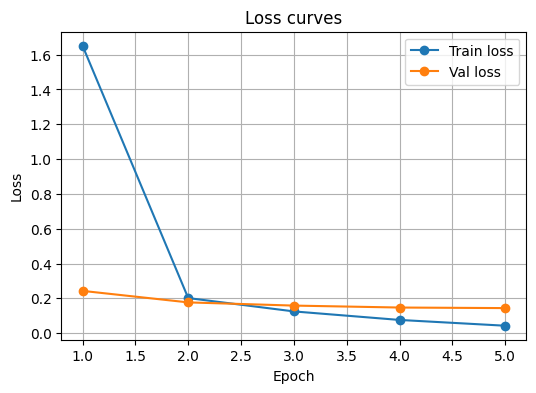

In [8]:
# --- Training vs Validation loss ---
plt.figure(figsize=(6,4))
plt.plot(df_train_log_history["epoch"], df_train_log_history["train_loss"], marker="o", label="Train loss")
plt.plot(df_train_log_history["epoch"], df_train_log_history["val_loss"], marker="o", label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss curves")
plt.grid(True); plt.legend(); plt.show()



### **Training Behaviour and Generalization**

- **Training loss** decreased sharply from ~1.65 (epoch 1) to ~0.04 (epoch 5).  
- **Validation loss** decreased steadily from ~0.24 to ~0.14 across epochs.  
- **Validation accuracy and macro-F1** improved consistently, reaching ~0.97 at epoch 5.  
- both training and validation losses decreased, and validation metrics continued to improve



---

**Conclusion:** This indicates **stable training** and **strong generalization potential**.  no clear signs of overfitting within 5 epochs; early stopping was not triggered prematurely. Early stopping was configured as a safeguard, but in this run the validation performance kept improving until the final epoch. The model therefore trained for all 5 epochs, without triggering early stopping.

---

**Overall:**  
The model shows healthy convergence, steadily improving validation metrics, and excellent final performance (~0.97 macro-F1 across 235 classes).


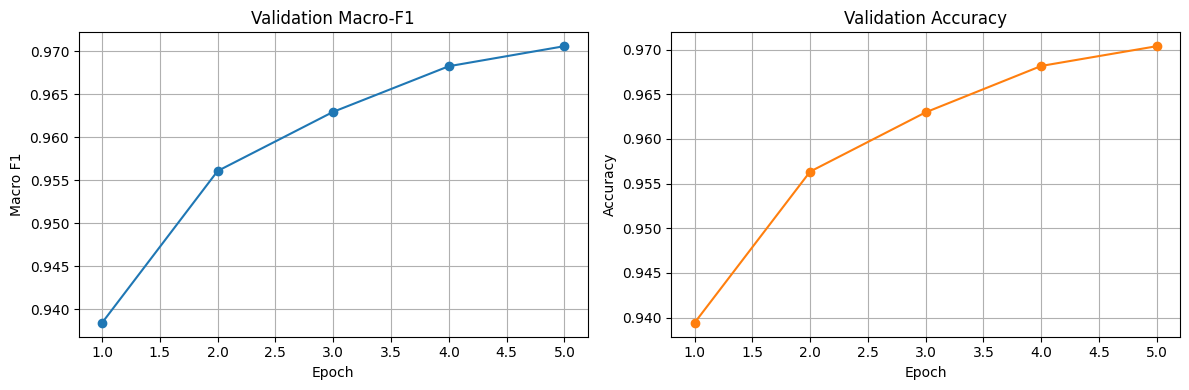

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# --- Validation macro-F1 ---
axes[0].plot(df_train_log_history["epoch"], df_train_log_history["val_macro_f1"], marker="o", color="C0")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Macro F1")
axes[0].set_title("Validation Macro-F1")
axes[0].grid(True)

# --- Validation accuracy ---
axes[1].plot(df_train_log_history["epoch"], df_train_log_history["val_accuracy"], marker="o", color="C1")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation Accuracy")
axes[1].grid(True)

plt.tight_layout()
plt.show()


**Conclusion:**:

Both validation Macro-F1 and Accuracy improved steadily across epochs, slightly exceeding the training values. It indicates stable training with no signs of overfitting.

In [12]:
# print validation performnace

# Path to the validation metrics
val_metrics_path = f"{PROJECT}/outputs/metrics/final_val_metrics.json"

# Load the JSON
with open(val_metrics_path, "r") as f:
    val_metrics = json.load(f)

# Pretty-print with rounding
pprint({k: round(v, 4) if isinstance(v, (int, float)) else v for k, v in val_metrics.items()})


{'epoch': 5.0,
 'eval_accuracy': 0.9704,
 'eval_loss': 0.1439,
 'eval_macro_f1': 0.9706,
 'eval_macro_precision': 0.9717,
 'eval_macro_recall': 0.9704,
 'eval_runtime': 10.4974,
 'eval_samples_per_second': 1119.324,
 'eval_steps_per_second': 35.056,
 'eval_weighted_f1': 0.9706}


### **XLM-R Validation Performance**

The model achieved strong validation results after 5 epochs:

- **Macro-F1**: **0.9710**  
- **Accuracy**: **0.9708**

Since the WiLI dataset is **balanced across 235 languages**, both overall **accuracy** and **macro-F1** are aligned.  


We report **macro-F1** as the main criterion, because it considers every class equally and ensures that all languages are represented fairly.  

For this reason, **macro-F1 was chosen as the optimization target** in Optuna, and also as the criterion for selecting the best model.  

The close agreement between **accuracy** and **macro-F1** confirms that the model generalizes well across all classes without bias toward frequent ones.


# **XLM-R Model Evaluation**

***Note: final_test_metrics.json in metrics folder contains the final evaluation of the model across all used metrics***

In [13]:
# Model evaluation

# Path to the evaluation metrics
test_metrics_path = f"{PROJECT}/outputs/metrics/final_test_metrics.json"

# Load the JSON
with open(test_metrics_path, "r") as f:
    test_metrics = json.load(f)

# Pretty-print with rounding
pprint({k: round(v, 4) if isinstance(v, (int, float)) else v for k, v in test_metrics.items()})


{'epoch': 5.0,
 'eval_accuracy': 0.9699,
 'eval_loss': 0.1471,
 'eval_macro_f1': 0.97,
 'eval_macro_precision': 0.9704,
 'eval_macro_recall': 0.9699,
 'eval_runtime': 101.9674,
 'eval_samples_per_second': 1152.329,
 'eval_steps_per_second': 36.012,
 'eval_weighted_f1': 0.97}


### **Model Evaluation**

The model achieved strong Macro-F1 and Accuracy results:

- **Macro-F1**: **0.97**  
- **Accuracy**: **0.9699**

The evaluation on the held-out test set shows metrics very close to the validation results, with **macro-F1 ≈ 0.97** and **accuracy ≈ 0.97**.  
This stability across validation and test splits indicates that the model has not overfit the validation data but instead learned patterns that generalize well.

The use of **macro-F1** is especially meaningful for language identification, since the dataset is balanced across 235 languages and each class is equally important.  

The alignment between macro-F1 and accuracy confirms that the model performs consistently across all languages, not only the majority classes.

**Overall**, the model demonstrates **robust generalization potential**: steady training/validation curves, stable validation–test performance, and high macro-F1 confirm its reliability for large-scale multilingual language detection.


# **Experimenting with Support Vector Machine (SVM) Traditional Model (TF-IDF n-grams) as a Baseline for Language Detection**

**Baseline: Linear SVM with TF-IDF n-grams (char/word)**
- Tuning on val_subset via Optuna (objective: macro-F1) on the same subsets used for tuning XLM-R
- Retrain on train+val splits (same ones used for XLM-R) with best params, then evaluate on test (same one used for XLM-R)
- Saves: best params, and metrics JSON

**Loading Data Splits**

In [ ]:
#Loading the full train\ validate\ test splits

train_ds = load_from_disk("path/to/your/train_split")
val_ds   = load_from_disk("path/to/your/data/validation_split")
test_ds  = load_from_disk("path/to/your/data/test_split")

train_ds_subset = load_from_disk("path/to/your/train_subset")
val_ds_subset   = load_from_disk("path/to/your/validation_subset")

In [8]:
print(f'Full Train Split Shape: {train_ds.shape}')
print(f'Full Validation Split Shape: {val_ds.shape}')
print(f'Full Test Split Shape: {test_ds.shape}')

print(f'Train Subset Shape: {train_ds_subset.shape}')
print(f'Validation Subset Shape: {val_ds_subset.shape}')

Full Train Split Shape: (105750, 2)
Full Validation Split Shape: (11750, 2)
Full Test Split Shape: (117500, 2)
Train Subset Shape: (21150, 2)
Validation Subset Shape: (2350, 2)


In [9]:
from language_id.data import to_xy

TEXT_COL  = "sentence"     # <— set to the text column name
LABEL_COL = "label"    # <— set to the label column name

# Prepare (X, y) for sklearn
X_train_subset, y_train_subset = to_xy(train_ds_subset, TEXT_COL, LABEL_COL)
X_val_subset,   y_val_subset   = to_xy(val_ds_subset,   TEXT_COL, LABEL_COL)

X_train, y_train = to_xy(train_ds, TEXT_COL, LABEL_COL)
X_val,   y_val   = to_xy(val_ds, TEXT_COL, LABEL_COL)
X_test,  y_test  = to_xy(test_ds, TEXT_COL, LABEL_COL)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)} | Train_Subset: {len(X_train_subset)} | Val: {len(X_val_subset)}" )
labels = sorted(set(y_train) | set(y_val) | set(y_test))
print("Num classes:", len(labels))



Train: 105750 | Val: 11750 | Test: 117500 | Train_Subset: 21150 | Val: 2350
Num classes: 235


**Optuna search space**

**Notes:**
- Char n-grams (3–5) are usually strong for language Identification.
- We keep LinearSVC (fast & strong). We tune C on a log scale.
- Objective = macro-F1 on **validation**.
- We used TF-IDF features with char_wb 3–5 n-grams (50k max features, sublinear term frequency, no lowercasing, min_df=1), and tuned only the SVM regularization parameter C in the range [1e-2, 1e2] using Optuna.


In [11]:
def build_pipeline(trial):
    # For language identification, character n-grams are usually the strongest features. Word n-grams add extra computation but rarely help much


    vectorizer = TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(3, 5),
        sublinear_tf=True,       # strong default for lang-ID
        lowercase=False,         # keep casing (can help distinguish)
        min_df=1,
        max_features=50_000,
        norm="l2",
        dtype=np.float32,
    )
    # Linear SVM
    C = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = LinearSVC(C=C, random_state=42)  # squared_hinge/L2 under the hood

    pipe = make_pipeline(vectorizer, clf)
    return pipe


def evaluate(pipe, X, y, label_list=None):
    pred = pipe.predict(X)
    acc = accuracy_score(y, pred)
    f1m = f1_score(y, pred, average="macro")
    return {"accuracy": acc, "macro_f1": f1m}


# Optuna objective

def objective(trial):
    pipe = build_pipeline(trial)
    pipe.fit(X_train_subset, y_train_subset)
    # labels arg isn't used; safe to drop it:
    metrics_val = evaluate(pipe, X_val_subset, y_val_subset)
    return metrics_val["macro_f1"]




In [12]:
def rebuild_best(params):
    vectorizer = TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(3, 5),
        sublinear_tf=True,
        lowercase=False,
        min_df=1,
        max_features=50_000,
        norm="l2",
        dtype=np.float32,
    )
    clf = LinearSVC(C=params["C"], random_state=42)
    return make_pipeline(vectorizer, clf)


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_full(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "macro_precision": precision_score(y_true, y_pred, average="macro"),
        "macro_recall": recall_score(y_true, y_pred, average="macro"),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    }


In [ ]:
N_TRIALS = 20

optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Best trial:")
print("value (val macro-F1):", study.best_value)
print("params:", study.best_params)


In [14]:
best_params = study.best_params
best_pipe = rebuild_best(best_params)

# Merge full train + val splits for final training
X_trval = list(X_train) + list(X_val)
y_trval = list(y_train) + list(y_val)

best_pipe.fit(X_trval, y_trval)

# Compute preds, then evaluate_full
y_val_pred  = best_pipe.predict(X_val)
y_test_pred = best_pipe.predict(X_test)

metrics_val  = evaluate_full(y_val,  y_val_pred)
metrics_test = evaluate_full(y_test, y_test_pred)

print("Validation metrics:", metrics_val)
print("Test metrics:", metrics_test)



Validation metrics: {'accuracy': 0.9945531914893617, 'macro_f1': 0.9947347194043873, 'macro_precision': 0.9960833637900361, 'macro_recall': 0.9945531914893618, 'weighted_f1': 0.9947347194043873}
Test metrics: {'accuracy': 0.9586297872340426, 'macro_f1': 0.9587407659056908, 'macro_precision': 0.960239069135015, 'macro_recall': 0.9586297872340425, 'weighted_f1': 0.9587407659056909}


## **Comparison between finetuned XLM-R and SVM Traditional Model baseline**

**SVM Validation:**

- **Macro-F1: 0.9947**
- **Accuracy:  0.9946**


---

**XLM-R Validation:**

- **Macro-F1: 0.971**
- **Accuracy: 0.9708**


---

**SVM Evaluation:**

- **Macro-F1: 0.9587**
- **Accuracy:  0.9586**

---

**XLM-R Evaluation:**

- **Macro-F1: 0.97**
- **Accuracy:  0.9699**


---

**Comment:**

**XLM-R** **maintained consistent performance across validation and test, highlighting its superior stability and generalization potential, which makes it more reliable in practice**

The SVM baseline reached very high validation scores, even surpassing **XLM-R** on the held-out validation split. However, its performance dropped noticeably on the test set (down by ~3.6 points in macro-F1). This gap suggests that the model may have overfit the validation split, likely memorizing frequent character patterns rather than learning features that generalize well. Despite being strong on frequent or easy-to-separate languages, its reliance on surface n-grams limits its robustness when faced with more diverse or rare examples in the test set.

Although the SVM baseline reached an exceptionally high macro-F1 on the validation split, its decline on the test set reveals weaker generalization.



In [ ]:
# Save artifacts

params_path  = f"{PROJECT}/outputs/metrics/svm_best_params.json"
metrics_path = f"{PROJECT}/outputs/metrics/svm_metrics.json"

with open(params_path, "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump({

        # Validation metrics

        "val_accuracy": metrics_val["accuracy"],
        "val_macro_f1": metrics_val["macro_f1"],
        "val_macro_precision": metrics_val["macro_precision"],
        "val_macro_recall": metrics_val["macro_recall"],
        "val_weighted_f1": metrics_val["weighted_f1"],

        # Test metrics
        "test_accuracy": metrics_test["accuracy"],
        "test_macro_f1": metrics_test["macro_f1"],
        "test_macro_precision": metrics_test["macro_precision"],
        "test_macro_recall": metrics_test["macro_recall"],
        "test_weighted_f1": metrics_test["weighted_f1"],

        "n_trials": N_TRIALS,
        "labels": labels
    }, f, ensure_ascii=False, indent=2)



print("Saved:")
print("Params :", params_path)
print("Metrics:", metrics_path)

